In [1]:
from google.colab import userdata
key = userdata.get('hf-api')

from huggingface_hub import login
login(token=key)

In [2]:
!pip install transformers --upgrade
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [3]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving BA_raw.csv to BA_raw.csv
Saving FB_raw.csv to FB_raw.csv
Saving JPM_raw.csv to JPM_raw.csv
User uploaded file "BA_raw.csv" with length 12009948 bytes
User uploaded file "FB_raw.csv" with length 21493979 bytes
User uploaded file "JPM_raw.csv" with length 12459623 bytes


In [7]:
!ls

BA_raw.csv  FB_raw.csv	JPM_raw.csv  sample_data


In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os, time
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [9]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
# get this python's directory
df = pd.read_csv('./FB_raw.csv') # data path of facebook stock price (Apr 2019 - Nov 2020)
close = np.array(df['close'])
logreturn = np.diff(np.log(close)) # Transform closing price to log returns, instead of using min-max scaler

csum_logreturn = logreturn.cumsum() # Cumulative sum of log returns

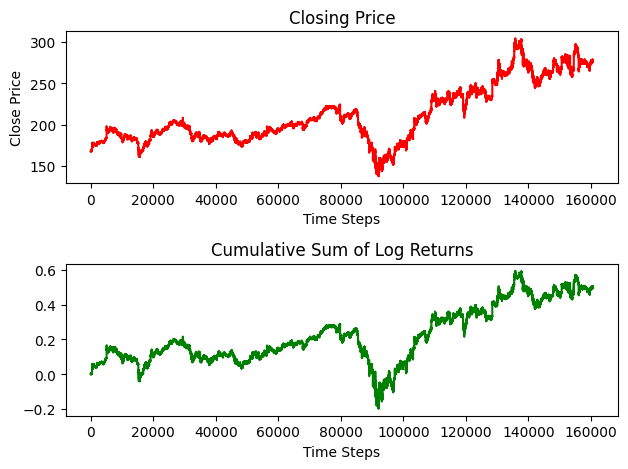

In [12]:

fig, axs = plt.subplots(2, 1)
axs[0].plot(close, color='red')
axs[0].set_title('Closing Price')
axs[0].set_ylabel('Close Price')
axs[0].set_xlabel('Time Steps')

axs[1].plot(csum_logreturn, color='green')
axs[1].set_title('Cumulative Sum of Log Returns')
axs[1].set_xlabel('Time Steps')

fig.tight_layout()
plt.show()


In [13]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [14]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)    # https://ok-lab.tistory.com/264
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask



In [15]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)


In [16]:
def get_data(data, split):
    """Split ratio of training data"""

    series = data

    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2*train_data # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
                              # Similar to image transformation to allow model to train on wider data sets

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

In [17]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target


In [18]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [19]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)


In [20]:
def model_forecast(model, seqence):
    model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):
            output = model(seq[-output_window:])
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

In [21]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval()
    forecast_seq = torch.Tensor(0)
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in tqdm(range(0, len(sequences) - 1)):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual


In [24]:
train_data, val_data = get_data(logreturn, 0.6) # 60% train, 40% test split
model = TransAm().to(device)

criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs = 3 # 100 # 500 # Number of epochs

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [25]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)

    else:
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step()


| epoch   1 |    77/  385 batches | lr 0.0000500000 | 12.48 ms | loss 0.1899645
| epoch   1 |   154/  385 batches | lr 0.0000500000 | 10.65 ms | loss 0.0195130
| epoch   1 |   231/  385 batches | lr 0.0000500000 | 10.65 ms | loss 0.0083246
| epoch   1 |   308/  385 batches | lr 0.0000500000 | 10.66 ms | loss 0.0066499
| epoch   1 |   385/  385 batches | lr 0.0000500000 | 13.40 ms | loss 0.0154104
--------------------------------------------------------------------------------
| end of epoch   1 | time:  4.45s
--------------------------------------------------------------------------------
| epoch   2 |    77/  385 batches | lr 0.0000451250 | 14.79 ms | loss 0.0072337
| epoch   2 |   154/  385 batches | lr 0.0000451250 | 16.63 ms | loss 0.0053469
| epoch   2 |   231/  385 batches | lr 0.0000451250 | 11.20 ms | loss 0.0032597
| epoch   2 |   308/  385 batches | lr 0.0000451250 | 10.76 ms | loss 0.0034403
| epoch   2 |   385/  385 batches | lr 0.0000451250 | 10.60 ms | loss 0.0096112
----

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:538: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


| epoch   3 |   231/  385 batches | lr 0.0000428687 | 14.28 ms | loss 0.0021421
| epoch   3 |   308/  385 batches | lr 0.0000428687 | 10.80 ms | loss 0.0041108


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:538: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


| epoch   3 |   385/  385 batches | lr 0.0000428687 | 11.05 ms | loss 0.0073719
--------------------------------------------------------------------------------
| end of epoch   3 | time:  5.60s | valid loss: 0.2458001
--------------------------------------------------------------------------------


In [26]:
test_result, truth = forecast_seq(model, val_data)


100%|██████████| 64259/64259 [01:15<00:00, 853.13it/s]

75.32552433013916 sec


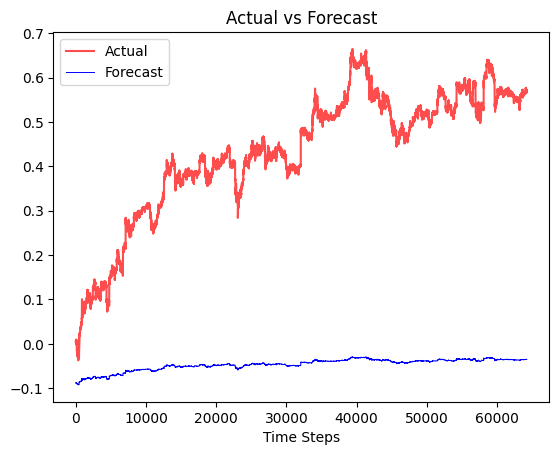

In [27]:
plt.plot(truth, color='red', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()


In [28]:
r = np.random.randint(100000, 160000)
test_forecast = model_forecast(model, csum_logreturn[r: r+10]) # random 10 sequence length

print(f"forecast sequence: {test_forecast}")
print(f"Actual sequence: {csum_logreturn[r: r+11]}")


forecast sequence: [ 0.48895794  0.49005362  0.49096578  0.48972505  0.49122104  0.49122104
  0.4905463   0.49100226  0.49060103  0.49218678 -0.04606961]
Actual sequence: [0.48895794 0.49005363 0.49096579 0.48972505 0.49122105 0.49122105
 0.4905463  0.49100226 0.49060103 0.49218678 0.49329713]


In [29]:
torch.save(model.state_dict(), "tr1-timeseries-model.pth")

model2 = TransAm() # rename as model2
model2.load_state_dict(torch.load("tr1-timeseries-model.pth"))
model2.to(device)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransAm(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
        )
        (linear1): Linear(in_features=250, out_features=2048, bias=True)
        (dropout): Dropout

In [32]:
df2 = pd.read_csv('./BA_raw.csv') # Boeing Co stock
close2 = df2['close'].fillna(method = 'ffill')
close2 = np.array(close2)
logreturn2 = np.diff(np.log(close2))

train_data2, val_data2 = get_data(logreturn2, 0.6)
test2_eval = evaluate(model2, val_data2)
print(f'Test 2 loss: {test2_eval :.5f}')

<ipython-input-32-9aee4d18455b>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close2 = df2['close'].fillna(method = 'ffill')


Test 2 loss: 0.07119


100%|██████████| 63571/63571 [01:14<00:00, 848.29it/s]


74.94285297393799 sec


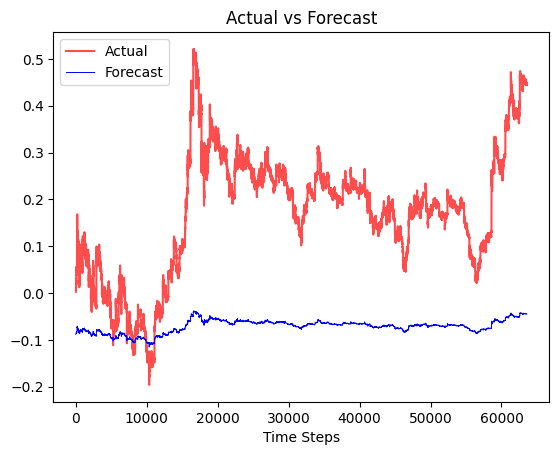

In [33]:
test_result2, truth2 = forecast_seq(model2, val_data2)

plt.plot(truth2, color='red', alpha=0.7)
plt.plot(test_result2, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()


In [35]:
df3 = pd.read_csv('./JPM_raw.csv') # JPMorgan Chase & Co stock
close3 = df3['close'].fillna(method = 'ffill')
close3 = np.array(close3)
logreturn3 = np.diff(np.log(close3))

train_data3, val_data3 = get_data(logreturn3, 0.6)
test3_eval = evaluate(model2, val_data3)
print(f'Test 3 loss: {test3_eval :.5f}')

<ipython-input-35-7e01e8793560>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close3 = df3['close'].fillna(method = 'ffill')


Test 3 loss: 0.03332


In [ ]:
test_result3, truth3 = forecast_seq(model2, val_data3)

plt.plot(truth3, color='red', alpha=0.7)
plt.plot(test_result3, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()


 42%|████▏     | 26738/63647 [00:31<00:40, 911.80it/s]